<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Up</a></span></li><li><span><a href="#Data-Validation/Check" data-toc-modified-id="Data-Validation/Check-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Validation/Check</a></span><ul class="toc-item"><li><span><a href="#Reverse-Calculations-Check" data-toc-modified-id="Reverse-Calculations-Check-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reverse Calculations Check</a></span></li><li><span><a href="#Energy-Use-Intensity-(EUI)-Check" data-toc-modified-id="Energy-Use-Intensity-(EUI)-Check-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Energy Use Intensity (EUI) Check</a></span></li><li><span><a href="#Rooftop-Angles-Adjustment" data-toc-modified-id="Rooftop-Angles-Adjustment-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Rooftop Angles Adjustment</a></span></li><li><span><a href="#Rooftop-Samples-Check" data-toc-modified-id="Rooftop-Samples-Check-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Rooftop Samples Check</a></span></li><li><span><a href="#New-Solar-Data-Source-Check" data-toc-modified-id="New-Solar-Data-Source-Check-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>New Solar Data Source Check</a></span></li></ul></li></ul></div>

## Set Up

In [63]:
def dataDir(x):
    return '/home/lucia/bu/year4/semester1/EE508/project/ma-solar/data/' + x

In [60]:
# Import libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from subprocess import Popen
from rasterstats import zonal_stats
from rasterio import open as r_open
from rasterio.plot import show as r_show 


%matplotlib inline

In [3]:
# Read the data to check

data = gpd.read_file(dataDir('analysisReady/roofsSolarIncomeTaxesEmissions.shp'))

## Data Validation/Check

In [9]:
data['emAvo_lbs'].sum() / 2205

5092575.498376043

I have a suspicion that either the emissions values or the potential energy values are too high. In 2019, the total emissions for electricity consumption in the City of Boston was 2 million metric tons of CO2-equivalents (MMTCO2e) ([source](https://www.boston.gov/departments/environment/bostons-carbon-emissions#:~:text=Overview,emitted%206.4%20million%20metric%20tons.)). Yet the total estimated emissions avoided by rooftop PV electricity generation in the study locations is over 5 million MTCO2e, more than double that reported for the electricity usage of the entire City. 

### Reverse Calculations Check

First, try to reverse the emissions calculation.

In [10]:
data.columns

Index(['STRUCT_ID', 'SOURCE', 'TOWN_ID', 'TOWN_ID2', 'LOCAL_ID', 'AREA_SQ_FT',
       'AREA_SQMI', 'index', 'CITY_TOWN', 'COUNTY', 'TRACTA', 'BLKGRPA',
       'NAME_E', 'NAME_M', 'GHIkWh/m^2', 'area_sq_m', 'potent_kWh',
       'potent_kW', 'kW', 'wAvgInc_l', 'wAvgInc_u', 'MAIncomeT', 'fedIncomeT',
       'emAvo_lbs', 'geometry'],
      dtype='object')

In [13]:
# try to sum MWh generated & reverse the emissions calculation

ch_c = data.copy()

# sum kWh generated and convert to MWh

ch_c['potent_MWh'] = ch_c['potent_kWh'] / 1000

M = ch_c['potent_MWh'].sum()
E = ch_c['emAvo_lbs'].sum()

print(E/M)  # should be ~780.6 (from EPA)

780.5999999999999


So, this calculation was done correctly given the inputs. Therefore there must be something off about the electricity generated.

### Energy Use Intensity (EUI) Check

Energy Use Intensity (EUI, kBTu/sqft) can give a picture of how realistic the estimate of potential electricity generated by rooftop PV systems could be. A value >300 would be unrealistic, and for context, the highest recorded for buildings on the BU campus is 150.

In [6]:
ch_e = data.copy()

ch_e['MMBTu'] = ch_e['potent_kWh'] * 0.003412  # kWh to MMBTu

# Compute EUI

M = ch_e['MMBTu'].sum() * 1000  # MMBTu to kBTu
A = ch_e['AREA_SQ_FT'].sum()    # total area

EUI = M/A
print(EUI)

457.40827246462624


457 is an unrealistic EUI value. Being so high, it means that the potential electricity generation is being overestimated. This is no surprise, since the data source, Global Horizontal Irradiance (GHI), measures the sunlight received by a surface that is horizontal to the ground. Certainly many rooftops in the study locations will be horizontal, but many will not. There is also of course the issue of shade from nearby buildings or trees and the orientation (N, S, W, E) of the panels, but an analysis of that level would require more time and data than currently available. Thus, I will try to adjust the energy generation values for realistic rooftop angles.

### Rooftop Angles Adjustment

In [15]:
ch_a = data.copy()

In [25]:
# Introduce a random variable for rooftop pitch, which is normally distributed 
# between 0 and 60 degrees

np.random.seed(42)

ch_a['pitch'] = np.random.randint(0, 60, ch_a.shape[0])    
ch_a['pitch']

0        38
1        51
2        28
3        14
4        42
         ..
65244     5
65245    31
65246    35
65247    53
65248    22
Name: pitch, Length: 65249, dtype: int64

Because of seasonal differences in the angle of the sun in the sky, a fixed PV system at about 40* latitude (Boston's latitude is ~42*) receives about 71% of the optimum radiance compared to a tracking system, even at the "annual average optimal" angle ([source](https://www.solarpaneltilt.com/)). 

At Boston's latitude, the "annual average optimal" tilt angle for a PV system is 42* ([source](https://news.energysage.com/solar-panel-performance-orientation-angle/)).

In Beek, a town in the Netherlands at latitude 51*, optimal tilting yields 14.6% greater output than with no tilting (horizontal placement) ([source](https://www.sciencedirect.com/science/article/pii/S0038092X1830375X?via%3Dihub)). As a crude estimation of the effect of tilt angles on PV generation on rooftops in Boston, I will use these percentages from Beek, which receives similar cloud cover annually. 

### New Solar Data Source Check

In [64]:
from_filepath = dataDir('irradiation2/USA_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas/western-hemisphere/PVOUT.tif')
to_filepath   = dataDir('irradiation2/USA_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas/western-hemisphere/solarPot.tif')

command = ['gdalwarp', 
           '-r', 'average',
            '-te', '-71.300', '42.170', '-71.000', '42.375',
           '-te_srs', 'EPSG:4326',
           '-of', 'GTiff',
           from_filepath, to_filepath]

Popen(command).wait()

0

In [65]:
solar_file = r_open(to_filepath)
solar = solar_file.read(1).astype(np.float32)

extent = [solar_file.bounds[i] for i in [0, 2, 1, 3]]

In [70]:
isolMA = gpd.read_file(dataDir('analysisReady/isolMA.shp')).to_crs('EPSG:4326')

Text(-71.085, 42.275, 'Milton')

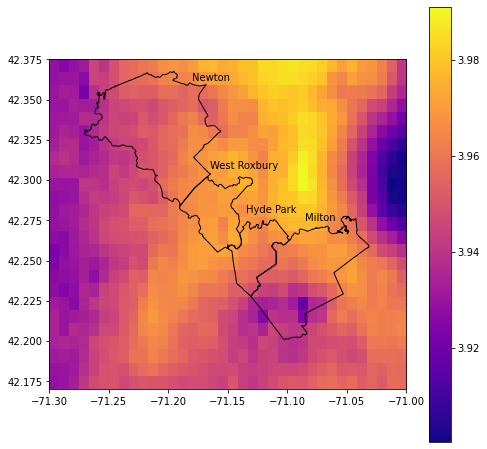

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

img = ax.imshow(solar, extent=extent, cmap='plasma')
plt.colorbar(img)

isolMA.plot(ax=ax, color='None', edgecolor='black')

# Town labels
ax.text(-71.180, 42.362, 'Newton')
ax.text(-71.165, 42.307, 'West Roxbury')
ax.text(-71.135, 42.280, 'Hyde Park')
ax.text(-71.085, 42.275, 'Milton')

#ax4.set_title('Global Horizontal Irradiation (GHI, kWh/m^2) in Towns')
#ax4.set_axis_off()

# Save image
#plt.savefig(outputDir('viz/GHItowns.png'), dpi=150, format='png')

In [86]:
roofs = gpd.read_file(dataDir('roofsALL/roofsGeometries.shp'))

In [76]:
path = to_filepath

solarzs    = zonal_stats(roofs, path, stats=['mean'], all_touched=True, nodata=-1)
roofsSolar = pd.DataFrame(solarzs, index=roofs.index)

In [77]:
roofs.columns

Index(['STRUCT_ID', 'SOURCE', 'TOWN_ID', 'TOWN_ID2', 'LOCAL_ID', 'AREA_SQ_FT',
       'AREA_SQMI', 'index', 'CITY_TOWN', 'COUNTY', 'MeanGHI_kW', 'area_sq_m',
       'potential_', 'geometry'],
      dtype='object')

In [88]:
# Store the zonal stats data in a new column
roofs['PV_kWh/kWp'] = roofsSolar['mean']

# Calculate the number of 320-Watt panels (17.5 ft^2 ea) that can fit on each roof
roofs['n_320Wp'] = roofs['AREA_SQ_FT'] / 17.5

# Calculate the approximate daily potential of each rooftop
roofs['potentkWh/day'] = ((roofs['n_320Wp'] * 320) / 1000) * roofs['PV_kWh/kWp']

# Calculate the yearly potential
roofs['potentkWh/yr'] = roofs['potentkWh/day'] * 365
roofs

,STRUCT_ID,SOURCE,TOWN_ID,TOWN_ID2,LOCAL_ID,AREA_SQ_FT,AREA_SQMI,index,CITY_TOWN,COUNTY,MeanGHI_kW,area_sq_m,potential_,geometry,PV_kWh/kWp,n_320Wp,potentkWh/day,potentkWh/yr
0,228564_891904,City of Boston,35,0,Bos_2003474000_B1,524.705830,5.350249,West Roxbury,BOSTON,SUFFOLK,1446.025024,48.746361,70488.457865,"POLYGON ((-71.15372 42.27713, -71.15366 42.277...",3.9695,29.983190,38.085848,13901.334608
1,228744_891768,City of Boston,35,0,Bos_2003510000_B0,1235.985434,5.350249,West Roxbury,BOSTON,SUFFOLK,1446.390015,114.825849,166082.960743,"POLYGON ((-71.15152 42.27592, -71.15150 42.275...",3.9635,70.627739,89.578575,32696.179702
2,228721_891681,City of Boston,35,0,Bos_2003527000_B0,1281.687169,5.350249,West Roxbury,BOSTON,SUFFOLK,1446.390015,119.071643,172224.036030,"POLYGON ((-71.15184 42.27513, -71.15183 42.275...",3.9635,73.239267,92.890827,33905.152015
3,229467_887834,City of Boston,35,0,Bos_1812932003_B0,1107.685557,4.440987,Hyde Park,BOSTON,SUFFOLK,1444.197998,102.906499,148617.360029,"POLYGON ((-71.14295 42.24045, -71.14295 42.240...",3.9580,63.296318,80.168583,29261.532722
4,229842_887062,City of Boston,35,0,Bos_1812996000_B0,1235.355673,4.440987,Hyde Park,BOSTON,SUFFOLK,1442.738037,114.767342,165579.210248,"POLYGON ((-71.13836 42.23341, -71.13835 42.233...",3.9530,70.591753,89.295745,32592.946968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65024,232602_889575,MAGIS,189,0,None,3318.360000,13.297527,Milton,"MILTON, TOWN OF",NORFOLK,1445.293945,308.283166,445559.793419,"POLYGON ((-71.10502 42.25603, -71.10494 42.256...",3.9620,189.620571,240.408539,87749.116662
65025,233037_889542,MAGIS,189,0,None,2043.410000,13.297527,Milton,"MILTON, TOWN OF",NORFOLK,1445.659058,189.837421,274440.187191,"POLYGON ((-71.09964 42.25556, -71.09974 42.255...",3.9630,116.766286,148.078335,54048.592312
65026,233261_889588,MAGIS,189,0,None,1100.700000,13.297527,Milton,"MILTON, TOWN OF",NORFOLK,1446.025024,102.257525,147866.940206,"POLYGON ((-71.09689 42.25599, -71.09698 42.256...",3.9630,62.897143,79.763642,29113.729285
65027,234126_889280,MAGIS,189,0,None,1562.920000,13.297527,Milton,"MILTON, TOWN OF",NORFOLK,1445.659058,145.198811,209907.976062,"POLYGON ((-71.08648 42.25316, -71.08655 42.253...",3.9660,89.309714,113.344747,41370.832613


In [89]:
# Calculate approximate hours of sun per year
roofs['sunhours'] = 2739

In [92]:
# Convert kWh to kW over the course of a year (divide by hours of sunlight)
roofs['potent_kW'] = roofs['potentkWh/yr'] / 2739

# Assume total energy loss = 14.08%
roofs['kW'] = roofs['potent_kW'] * 0.8592
roofs

,STRUCT_ID,SOURCE,TOWN_ID,TOWN_ID2,LOCAL_ID,AREA_SQ_FT,AREA_SQMI,index,CITY_TOWN,COUNTY,...,area_sq_m,potential_,geometry,PV_kWh/kWp,n_320Wp,potentkWh/day,potentkWh/yr,sunhours,potent_kW,kW
0,228564_891904,City of Boston,35,0,Bos_2003474000_B1,524.705830,5.350249,West Roxbury,BOSTON,SUFFOLK,...,48.746361,70488.457865,"POLYGON ((-71.15372 42.27713, -71.15366 42.277...",3.9695,29.983190,38.085848,13901.334608,2739,5.075332,4.360725
1,228744_891768,City of Boston,35,0,Bos_2003510000_B0,1235.985434,5.350249,West Roxbury,BOSTON,SUFFOLK,...,114.825849,166082.960743,"POLYGON ((-71.15152 42.27592, -71.15150 42.275...",3.9635,70.627739,89.578575,32696.179702,2739,11.937269,10.256501
2,228721_891681,City of Boston,35,0,Bos_2003527000_B0,1281.687169,5.350249,West Roxbury,BOSTON,SUFFOLK,...,119.071643,172224.036030,"POLYGON ((-71.15184 42.27513, -71.15183 42.275...",3.9635,73.239267,92.890827,33905.152015,2739,12.378661,10.635745
3,229467_887834,City of Boston,35,0,Bos_1812932003_B0,1107.685557,4.440987,Hyde Park,BOSTON,SUFFOLK,...,102.906499,148617.360029,"POLYGON ((-71.14295 42.24045, -71.14295 42.240...",3.9580,63.296318,80.168583,29261.532722,2739,10.683291,9.179083
4,229842_887062,City of Boston,35,0,Bos_1812996000_B0,1235.355673,4.440987,Hyde Park,BOSTON,SUFFOLK,...,114.767342,165579.210248,"POLYGON ((-71.13836 42.23341, -71.13835 42.233...",3.9530,70.591753,89.295745,32592.946968,2739,11.899579,10.224118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65024,232602_889575,MAGIS,189,0,None,3318.360000,13.297527,Milton,"MILTON, TOWN OF",NORFOLK,...,308.283166,445559.793419,"POLYGON ((-71.10502 42.25603, -71.10494 42.256...",3.9620,189.620571,240.408539,87749.116662,2739,32.036917,27.526119
65025,233037_889542,MAGIS,189,0,None,2043.410000,13.297527,Milton,"MILTON, TOWN OF",NORFOLK,...,189.837421,274440.187191,"POLYGON ((-71.09964 42.25556, -71.09974 42.255...",3.9630,116.766286,148.078335,54048.592312,2739,19.732965,16.954564
65026,233261_889588,MAGIS,189,0,None,1100.700000,13.297527,Milton,"MILTON, TOWN OF",NORFOLK,...,102.257525,147866.940206,"POLYGON ((-71.09689 42.25599, -71.09698 42.256...",3.9630,62.897143,79.763642,29113.729285,2739,10.629328,9.132719
65027,234126_889280,MAGIS,189,0,None,1562.920000,13.297527,Milton,"MILTON, TOWN OF",NORFOLK,...,145.198811,209907.976062,"POLYGON ((-71.08648 42.25316, -71.08655 42.253...",3.9660,89.309714,113.344747,41370.832613,2739,15.104357,12.977663


In [95]:
roofs['kW'].quantile(np.linspace(.1, 1, 9, 0))

0.1     2.049888
0.2     3.912318
0.3     7.065933
0.4     8.727529
0.5    10.131357
0.6    11.589598
0.7    13.276143
0.8    15.614386
0.9    20.645808
Name: kW, dtype: float64

In [103]:
# Re-check the EUI

roofs['MMBTu'] = roofs['potentkWh/yr'] * 0.003412  # kWh to MMBTu

# Compute EUI

M = roofs['MMBTu'].sum() * 1000  # MMBTu to kBTu
A = roofs['AREA_SQ_FT'].sum()    # total area

EUI = M/A
print(EUI)

90.16183861668524


This seems much more reasonable. Now I need to replace the solar data in the initViz file with this data.

In [ ]:
# BU Wind operational hours of the U.
# https://www.bu.edu/sustainability/projects/bu-wind/
# https://www.solar-estimate.org/residential-solar/solar-panels/massachusetts?aff=4713&cam=45&gclid=CjwKCAiA55mPBhBOEiwANmzoQrxFm9ILp4JeIUbNCRJ2SxDEUzEPz4nGNqYFAv9zQputiCc6pZrrkhoCK1EQAvD_BwE

In [ ]:
# MA daylight hours: https://www.boston.climatemps.com/sunlight.php